# Predicting the total and electronic dielectric constant from composition features: Decreasing number of features, changing model architecture

### Summary:
Dielectric constants are important in designing battery electrolyte. Here, we can try to predict them from composition properties alone  
**The datapoints are modified; X: log(1+X) to decrease variance**  
**Cross Validation added (K-fold) to determine reliance on the way train/test datapoints are split**
**Stratified split with binned target to ensure similar train/test distribution and reduce reliance on the way train/test datapoints are split**
**Top 50 features for total dielectric constant chosen instead of 132 Magpie features**  
**Moving from Random Forest to Histogram-based Gradient Boosting Regression Tree with multi target regressor**  

**Methodology:**  
**Dataset:** dielectric_constant from Matminer  
**X_train:** 50 best Magpie features, Element Property; log(1+X) modification  
**Model:** Histogram-based Gradient Boosting Regression Tree with multi target regressor
**N:** 1056 (80/20 split) with stratified splitting   

**Key Findings:**  
Selecting more than 50 best features for training does not result in a better fit  
Histogram-based Gradient Boosting Regression Tree with multi target regressor works better than Random Forest  
Using two models to predict the two dielectric constants performs worse than one joint model predicting both  
Using two different set of 50 best features for the two dielectric constants performs worse than just using the 50 best features for the total dielectric constant  

**Causes:**  
a) ~~Outliers skew the data and the model can't capture them accurately~~  
b) ~~Since there are only ~800 datapoints, the way we split the train/test set affects the model starkly (random_state variable)~~  
c) The regression model is too complex for just ~800 training datapoints  

In [2]:
# %pip install matminer scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, RepeatedKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from pymatgen.core import Composition
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

import warnings
warnings.filterwarnings('ignore')

rs = 82 #random_state variable

In [3]:
# Load dataset
df = load_dataset('dielectric_constant')
df.head()


,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


In [4]:
# Featurize composition
ep = ElementProperty.from_preset(preset_name="magpie")
df['composition'] = df['formula'].apply(Composition)
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar,composition
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...,"(Rb, Te)"
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...,"(Cd, Cl)"
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...,"(Mn, I)"
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...,"(La, N)"
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...,"(Mn, F)"


In [5]:
df['e_total_scalar'] = df['e_total'].apply(lambda x: np.trace(np.array(ast.literal_eval(x))) / 3 if isinstance(x, str) else np.nan)
df['e_electronic_scalar'] = df['e_electronic'].apply(lambda x: np.trace(np.array(ast.literal_eval(x))) / 3 if isinstance(x, str) else np.nan)
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar,composition,e_total_scalar,e_electronic_scalar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...,"(Rb, Te)",6.234922,3.441253
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...,"(Cd, Cl)",6.726629,3.156762
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...,"(Mn, I)",10.642403,4.974772
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...,"(La, N)",17.992909,7.036249
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...,"(Mn, F)",7.118792,2.352712


In [6]:
df = ep.featurize_dataframe(df, "composition", ignore_errors=True)
X = df[ep.feature_labels()]
y = df[['e_total_scalar', 'e_electronic_scalar']]
#X.to_pickle('X.pkl')
#y.to_pickle('y.pkl')

ElementProperty:   0%|          | 0/1056 [00:00<?, ?it/s]

In [7]:
X.head()
#X.shape

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,37.0,52.0,15.0,42.000000,6.666667,37.0,4.0,90.0,86.0,32.666667,...,0.00000,0.000000,0.000000,0.0,152.0,229.0,77.0,203.333333,34.222222,229.0
1,17.0,48.0,31.0,27.333333,13.777778,17.0,70.0,94.0,24.0,86.000000,...,0.00000,0.000000,0.000000,0.0,64.0,194.0,130.0,107.333333,57.777778,64.0
2,25.0,53.0,28.0,43.666667,12.444444,53.0,52.0,96.0,44.0,81.333333,...,0.00031,0.000103,0.000138,0.0,64.0,217.0,153.0,115.000000,68.000000,64.0
3,7.0,57.0,50.0,32.000000,25.000000,7.0,13.0,82.0,69.0,47.500000,...,0.00000,0.000000,0.000000,0.0,194.0,194.0,0.0,194.000000,0.000000,194.0
4,9.0,25.0,16.0,14.333333,7.111111,9.0,52.0,93.0,41.0,79.333333,...,0.00031,0.000103,0.000138,0.0,15.0,217.0,202.0,82.333333,89.777778,15.0


In [8]:
#X = pd.read_pickle('X.pkl')
#y = pd.read_pickle('y.pkl')
#X.shape()
#y.shape()

# Bin the target
y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train, y_train_log['e_total_scalar'])
X_test_selected  = selector.transform(X_test)


# Train multi-output regressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=rs))
#model.fit(X_train, y_train_log)
model.fit(X_train_selected, y_train_log)

MultiOutputRegressor(estimator=RandomForestRegressor(random_state=82))

In [9]:
# Predict and evaluate

y_pred_log = model.predict(X_test_selected)
y_pred = np.expm1(y_pred_log)
y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
y_cv_pred_log = cross_val_predict(model, X_train_selected, y_train_log, cv=kf)
y_cv_pred = np.expm1(y_cv_pred_log)

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred[:, 0])
cv_rmse, cv_r2 = compute_metrics(y_train['e_total_scalar'], y_cv_pred[:, 0])
test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred[:, 0])
train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred[:, 1])
cv_rmse_e, cv_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_cv_pred[:, 1])
test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred[:, 1])

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
df_metrics_total


,Train,CV,Test
RMSE total,10.924,18.787,9.955
R$^2$ total,0.721,0.174,0.442
RMSE elec,7.756,12.633,5.738
R$^2$ elec,0.688,0.171,0.596


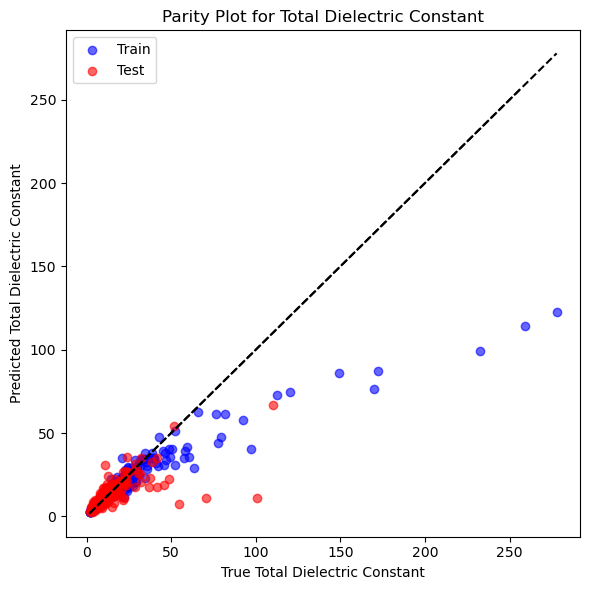

In [10]:
# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_train['e_total_scalar'], y_train_pred[:, 0], alpha=0.6, color='b', marker='o', label='Train')
plt.scatter(y_test['e_total_scalar'], y_pred[:, 0], alpha=0.6, color='r', marker='o', label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel("True Total Dielectric Constant")
plt.ylabel("Predicted Total Dielectric Constant")
plt.title("Parity Plot for Total Dielectric Constant")
plt.legend()
plt.tight_layout()
plt.show()

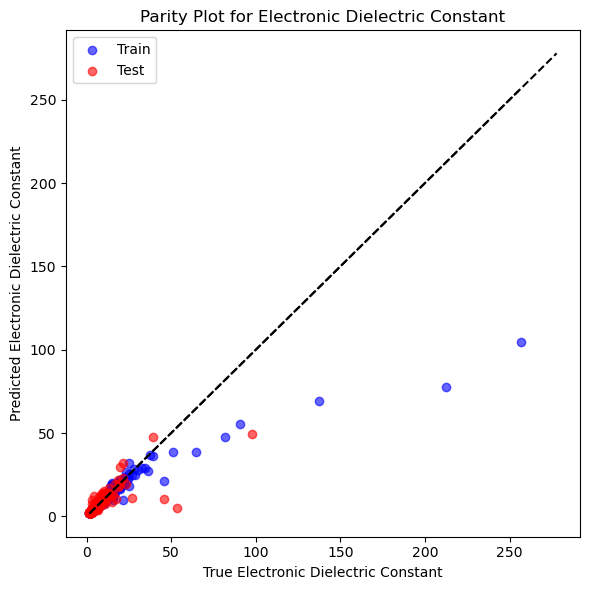

In [11]:
# Parity plot
plt.figure(figsize=(6,6))
plt.scatter(y_train['e_electronic_scalar'], y_train_pred[:, 1], alpha=0.6, color='b', marker='o', label='Train')
plt.scatter(y_test['e_electronic_scalar'], y_pred[:, 1], alpha=0.6, color='r', marker='o', label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')
plt.xlabel("True Electronic Dielectric Constant")
plt.ylabel("Predicted Electronic Dielectric Constant")
plt.title("Parity Plot for Electronic Dielectric Constant")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#Trying to analyze effect of number of features (X data) that result in best fit
#Result: Not much of a difference. Number of features above 50 do not make a large difference. Setting it at 50

y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train multi-output regressor
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=rs))

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2

for n_features in range(10, 131, 20):
    selector = SelectKBest(f_regression, k=n_features)
    X_train_selected = selector.fit_transform(X_train, y_train_log['e_total_scalar'])
    X_test_selected  = selector.transform(X_test)

    #model.fit(X_train, y_train_log)
    model.fit(X_train_selected, y_train_log)

    # Predict and evaluate

    y_pred_log = model.predict(X_test_selected)
    y_pred = np.expm1(y_pred_log)
    y_train_pred_log = model.predict(X_train_selected)
    y_train_pred = np.expm1(y_train_pred_log)

    kf = KFold(n_splits=5, shuffle=True, random_state=rs)
    y_cv_pred_log = cross_val_predict(model, X_train_selected, y_train_log, cv=kf)
    y_cv_pred = np.expm1(y_cv_pred_log)

    # Compute metrics for each set
    train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred[:, 0])
    cv_rmse, cv_r2 = compute_metrics(y_train['e_total_scalar'], y_cv_pred[:, 0])
    test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred[:, 0])
    train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred[:, 1])
    cv_rmse_e, cv_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_cv_pred[:, 1])
    test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred[:, 1])

    # Create DataFrame
    df_metrics_total = pd.DataFrame({
        'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
        'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
        'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
    }, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

    # Display the table
    display(df_metrics_total)
    #print("done")

,Train,CV,Test
RMSE total,11.100,18.980,10.668
R$^2$ total,0.712,0.157,0.359
RMSE elec,7.775,12.629,5.625
R$^2$ elec,0.686,0.172,0.611


,Train,CV,Test
RMSE total,11.016,18.849,10.047
R$^2$ total,0.716,0.169,0.431
RMSE elec,7.790,12.531,5.908
R$^2$ elec,0.685,0.185,0.571


,Train,CV,Test
RMSE total,10.924,18.787,9.955
R$^2$ total,0.721,0.174,0.442
RMSE elec,7.756,12.633,5.738
R$^2$ elec,0.688,0.171,0.596


,Train,CV,Test
RMSE total,11.027,18.778,10.138
R$^2$ total,0.716,0.175,0.421
RMSE elec,7.928,12.619,5.775
R$^2$ elec,0.674,0.173,0.590


,Train,CV,Test
RMSE total,10.853,18.824,9.945
R$^2$ total,0.724,0.171,0.443
RMSE elec,7.964,12.680,5.647
R$^2$ elec,0.671,0.165,0.608


,Train,CV,Test
RMSE total,10.688,18.759,10.021
R$^2$ total,0.733,0.177,0.434
RMSE elec,8.078,12.707,5.602
R$^2$ elec,0.661,0.161,0.615


,Train,CV,Test
RMSE total,10.664,18.817,9.945
R$^2$ total,0.734,0.172,0.443
RMSE elec,8.036,12.701,5.733
R$^2$ elec,0.665,0.162,0.596


In [17]:
#Objective: Observing the effect of HistGradientBoostingRegressor: best
#Result: Training data is fit better (Overfitting). Fit results improve for electronic dielectric constant in train, CV, and test datasets

# Bin the target
y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train multi-output regressor
from sklearn.ensemble import HistGradientBoostingRegressor
model = MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=300, random_state=rs))
#model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=rs))

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2


selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train, y_train_log['e_total_scalar'])
X_test_selected  = selector.transform(X_test)

#model.fit(X_train, y_train_log)
model.fit(X_train_selected, y_train_log)

# Predict and evaluate

y_pred_log = model.predict(X_test_selected)
y_pred = np.expm1(y_pred_log)
y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
y_cv_pred_log = cross_val_predict(model, X_train_selected, y_train_log, cv=kf)
y_cv_pred = np.expm1(y_cv_pred_log)

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred[:, 0])
cv_rmse, cv_r2 = compute_metrics(y_train['e_total_scalar'], y_cv_pred[:, 0])
test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred[:, 0])
train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred[:, 1])
cv_rmse_e, cv_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_cv_pred[:, 1])
test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred[:, 1])

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
display(df_metrics_total)
#print("done")

,Train,CV,Test
RMSE total,6.061,18.963,10.145
R$^2$ total,0.914,0.159,0.420
RMSE elec,5.258,12.301,5.059
R$^2$ elec,0.856,0.214,0.686


In [18]:
#Objective: Reduce overfitting of train data by introducing regularization and constraining depth
#Result: Underfitting of data (esp e_electronic)

# Bin the target
y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train multi-output regressor
from sklearn.ensemble import HistGradientBoostingRegressor

model = MultiOutputRegressor(HistGradientBoostingRegressor(
    max_iter=300,
    max_depth=7,
    learning_rate=0.05,
    l2_regularization=0.1,  # regularization
    min_samples_leaf=5,     # local fit
    early_stopping=True,
    random_state=rs
))

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2


selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train, y_train_log['e_total_scalar'])
X_test_selected  = selector.transform(X_test)



#model.fit(X_train, y_train_log)
model.fit(X_train_selected, y_train_log)

# Predict and evaluate

y_pred_log = model.predict(X_test_selected)
y_pred = np.expm1(y_pred_log)
y_train_pred_log = model.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
y_cv_pred_log = cross_val_predict(model, X_train_selected, y_train_log, cv=kf)
y_cv_pred = np.expm1(y_cv_pred_log)

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred[:, 0])
cv_rmse, cv_r2 = compute_metrics(y_train['e_total_scalar'], y_cv_pred[:, 0])
test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred[:, 0])
train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred[:, 1])
cv_rmse_e, cv_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_cv_pred[:, 1])
test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred[:, 1])

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
display(df_metrics_total)
#print("done")

,Train,CV,Test
RMSE total,8.590,18.951,9.833
R$^2$ total,0.827,0.160,0.455
RMSE elec,6.618,12.473,5.576
R$^2$ elec,0.773,0.192,0.618


In [19]:
#Objective: Instead of multi output regressor, using two different models for total and electronic dielectric constant to see if 
#           that improves the fit
#Result: Total dielectric fits unchanged but Electronic dielectric fits worsen; potentially due to the target being binned using only the total dielectric constant

# Bin the target
y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y_binned, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Train multi-output regressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Model for ε_total (needs flexibility)
model_total = HistGradientBoostingRegressor(
    max_iter=300, max_depth=7, learning_rate=0.05,
    l2_regularization=0.1, min_samples_leaf=5, early_stopping=True, random_state=rs
)

# Model for ε_elec (benefits from stronger regularization)
model_elec = HistGradientBoostingRegressor(
    max_iter=300, max_depth=6, learning_rate=0.05,
    l2_regularization=1.0, min_samples_leaf=10, early_stopping=True, random_state=rs
)
#model = MultiOutputRegressor(HistGradientBoostingRegressor(max_iter=300, max_depth=6, learning_rate=0.05, l2_regularization=1.0, early_stopping=True))
#model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=rs))

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2


selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train, y_train_log['e_total_scalar'])
X_test_selected  = selector.transform(X_test)



#model.fit(X_train, y_train_log)
model_total.fit(X_train_selected, y_train_log['e_total_scalar'])
model_elec.fit(X_train_selected, y_train_log['e_electronic_scalar'])

# Predict and evaluate

y_train_pred_log = y_cv_pred_log = pd.DataFrame(np.nan, index=y_train.index, columns=y_train.columns)
y_pred_log = pd.DataFrame(np.nan, index=y_test.index, columns=y_test.columns)
y_pred_log
y_pred_log['e_total_scalar'] = model_total.predict(X_test_selected)
y_pred_log['e_electronic_scalar'] = model_elec.predict(X_test_selected)
y_pred = np.expm1(y_pred_log)
y_train_pred_log['e_total_scalar'] = model_total.predict(X_train_selected)
y_train_pred_log['e_electronic_scalar'] = model_elec.predict(X_train_selected)
y_train_pred = np.expm1(y_train_pred_log)

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
y_cv_pred_log['e_total_scalar'] = cross_val_predict(model_total, X_train_selected, y_train_log['e_total_scalar'], cv=kf)
y_cv_pred_log['e_electronic_scalar'] = cross_val_predict(model_elec, X_train_selected, y_train_log['e_electronic_scalar'], cv=kf)
y_cv_pred = np.expm1(y_cv_pred_log)

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train['e_total_scalar'], y_train_pred['e_total_scalar'])
cv_rmse, cv_r2 = compute_metrics(y_train['e_total_scalar'], y_cv_pred['e_total_scalar'])
test_rmse, test_r2 = compute_metrics(y_test['e_total_scalar'], y_pred['e_total_scalar'])
train_rmse_e, train_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_train_pred['e_electronic_scalar'])
cv_rmse_e, cv_r2_e = compute_metrics(y_train['e_electronic_scalar'], y_cv_pred['e_electronic_scalar'])
test_rmse_e, test_r2_e = compute_metrics(y_test['e_electronic_scalar'], y_pred['e_electronic_scalar'])

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
display(df_metrics_total)
#print("done")

,Train,CV,Test
RMSE total,8.590,18.951,9.833
R$^2$ total,0.827,0.160,0.455
RMSE elec,8.680,12.446,6.060
R$^2$ elec,0.609,0.196,0.549


In [20]:
#Objective: Using two different models for total and electronic dielectric constant with targets binned separately for each model 
#           that improves the fit
#Result: Results in worse electronic dielectric fits

# Bin the target
y_binned = pd.qcut(y['e_total_scalar'], q=10, duplicates='drop')  # quantile-based bins
y_binned_e = pd.qcut(y['e_electronic_scalar'], q=10, duplicates='drop')  # quantile-based bins

# Stratified split using binned target
X_train, X_test, y_train, y_test = train_test_split(X, y['e_total_scalar'], stratify=y_binned, test_size=0.2, random_state=rs)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y['e_electronic_scalar'], stratify=y_binned_e, test_size=0.2, random_state=rs)

# Train/test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
y_train_log_e = np.log1p(y_train_e)
y_test_log_e = np.log1p(y_test_e)

# Train multi-output regressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Model for ε_total (needs flexibility)
model_total = HistGradientBoostingRegressor(
    max_iter=300, max_depth=7, learning_rate=0.05,
    l2_regularization=0.1, min_samples_leaf=5, early_stopping=True, random_state=rs
)

# Model for ε_elec (benefits from stronger regularization)
model_elec = HistGradientBoostingRegressor(
    max_iter=300, max_depth=6, learning_rate=0.05,
    l2_regularization=1.0, min_samples_leaf=10, early_stopping=True, random_state=rs
)

def compute_metrics(y_true, y_pred):
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    return rmse, r2


selector = SelectKBest(f_regression, k=50)
X_train_selected = selector.fit_transform(X_train, y_train_log)
X_test_selected  = selector.transform(X_test)

X_train_selected_e = selector.fit_transform(X_train_e, y_train_log_e)
X_test_selected_e  = selector.transform(X_test_e)

#model.fit(X_train, y_train_log)
model_total.fit(X_train_selected, y_train_log)
model_elec.fit(X_train_selected_e, y_train_log_e)

y_pred_log = model_total.predict(X_test_selected)
y_pred_log_e = model_elec.predict(X_test_selected_e)
y_pred = np.expm1(y_pred_log)
y_pred_e = np.expm1(y_pred_log_e)
y_train_pred_log = model_total.predict(X_train_selected)
y_train_pred_log_e = model_elec.predict(X_train_selected_e)
y_train_pred = np.expm1(y_train_pred_log)
y_train_pred_e = np.expm1(y_train_pred_log_e)

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
y_cv_pred_log = cross_val_predict(model_total, X_train_selected, y_train_log, cv=kf)
y_cv_pred_log_e = cross_val_predict(model_elec, X_train_selected_e, y_train_log_e, cv=kf)
y_cv_pred = np.expm1(y_cv_pred_log)
y_cv_pred_e = np.expm1(y_cv_pred_log_e)

# Compute metrics for each set
train_rmse, train_r2 = compute_metrics(y_train, y_train_pred)
cv_rmse, cv_r2 = compute_metrics(y_train, y_cv_pred)
test_rmse, test_r2 = compute_metrics(y_test, y_pred)
train_rmse_e, train_r2_e = compute_metrics(y_train_e, y_train_pred_e)
cv_rmse_e, cv_r2_e = compute_metrics(y_train_e, y_cv_pred_e)
test_rmse_e, test_r2_e = compute_metrics(y_test_e, y_pred_e)

# Create DataFrame
df_metrics_total = pd.DataFrame({
    'Train': [train_rmse, train_r2, train_rmse_e, train_r2_e],
    'CV': [cv_rmse, cv_r2, cv_rmse_e, cv_r2_e],
    'Test': [test_rmse, test_r2,test_rmse_e, test_r2_e]
}, index=['RMSE total', 'R$^2$ total','RMSE elec', 'R$^2$ elec' ])

# Display the table
display(df_metrics_total)
#print("done")

,Train,CV,Test
RMSE total,8.590,18.951,9.833
R$^2$ total,0.827,0.160,0.455
RMSE elec,9.716,11.778,9.868
R$^2$ elec,0.459,0.206,0.363
